In [1]:
import gensim.downloader as api
import pandas as pd
import numpy as np
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
wv = api.load('glove-wiki-gigaword-300')

[===-----------------------------------------------] 6.2% 23.4/376.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=======-------------------------------------------] 14.5% 54.7/376.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===========---------------------------------------] 23.5% 88.5/376.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[================----------------------------------] 32.5% 122.1/376.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[====================------------------------------] 41.5% 156.2/376.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=========================-------------------------] 50.5% 189.8/376.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=============================---------------------] 59.3% 223.1/376.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================================----------------] 68.2% 256.5/376.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[======================================------------] 77.1% 290.0/376.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==========================================--------] 85.9% 323.0/376.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===============================================---] 94.6% 355.9/376.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================================================] 100.0% 376.1/376.1MB downloaded


In [2]:
csv1 = "../../data/cleaned/final_clean_data1.csv"
csv2 = "../../data/cleaned/final_clean_data2.csv"
base_texts = pd.read_csv(csv1).iloc[:, 0]
anomaly_texts = pd.read_csv(csv2).iloc[:, 0]

In [3]:
def key_words(column, top_n=20):
    """
    En utilisant la métrique tf-dif, la fonction retourne les top_n premiers mots-clés dans le dataset.
    """
    vectorizer = TfidfVectorizer()
    x = vectorizer.fit_transform(column)
    feature_names = vectorizer.get_feature_names_out()
    
    kw_per_text = []
    for doc_idx in range(x.shape[0]):
        # récupérer les scores tf-dif pour le texte courant
        tfidf_scores = x[doc_idx].toarray()[0]

        # associer chaque mot avec son score tf-dif
        word_scores = [(feature_names[i], tfidf_scores[i]) for i in range(len(feature_names))]

        # trier les mots par score décroissant
        sorted_words = sorted(word_scores, key=lambda x: x[1], reverse=True)

        # récupérer les top_n mots-clés
        keywords = [word for word, score in sorted_words[:top_n]]
        kw_per_text.append(keywords)

    return kw_per_text

In [4]:
def contamination_function(data1, data2, contamination_rate=0.5):
    contaminated_texts = []
    contamination_log = []
    data1_kw = key_words(data1)
    data2_kw = key_words(data2)
    
    #on prend 15% des documents 
    df_size = max(1, int(len(data1) * 0.15))  
    selected_indices = random.sample(range(len(data1)), df_size)


    #pour mesurer la similarité entre les mots-clés
    vectorizer = TfidfVectorizer()
    all_keywords = data1_kw + data2_kw
    tfidf_matrice = vectorizer.fit_transform([' '.join(kw) for kw in all_keywords]) #matrice de tout les mots clés
    base_vectors = tfidf_matrice[:len(data1_kw)] 
    anomaly_vectors = tfidf_matrice[len(data1_kw):]
    
    for i in selected_indices:
        base_text = data1[i]
        words = base_text.split()  
        total_words = len(words)
        words_to_contaminate = max(1, int(total_words * contamination_rate))  # mots à contaminer
        # trouver les anomalies les moins similaires (mots clés du text avec toutes les anomalies)
        similarities = cosine_similarity(base_vectors[i], anomaly_vectors)
        best_anomaly_idx = similarities.argmin()
        anomaly_text = data2[best_anomaly_idx]
        anomaly_words = anomaly_text.split()  # les mots de l'anomalie
        # tontaminer les mots du texte de base
        contaminated_words = words[:]
        contaminated_positions = []

        for _ in range(words_to_contaminate):
            # choisir un mot d'anomalie aléatoire
            anomaly_word = random.choice(anomaly_words)
            #position aléatoire dans le document de base
            position = random.randint(0, total_words - 1)

            # mettre le mot à cette position
            contaminated_words[position] = anomaly_word
            contaminated_positions.append((position, anomaly_word))

        #le texte contaminé
        contaminated_text = ' '.join(contaminated_words)
        contaminated_texts.append(contaminated_text)
        data1[i] = contaminated_text

        #résumé des contaminations (à supprimer aprés)
        contamination_log.append({
            "base_text": base_text,
            "contaminated_text": contaminated_text,
            "contaminated_positions": contaminated_positions,
            "anomaly_text": anomaly_text
        })

    return data1, contamination_log, selected_indices

In [5]:
contaminated, log, indices = contamination_function(base_texts, anomaly_texts)
log

[{'base_text': 'stable_mild cardiac enlargement lung clear pleural line suggest pneumothora costophrenic anonym blunting suggest large pleural effusion bony structure within normal limit stable_mild cardiomegaly acute cardiopulmonary finding',
  'contaminated_text': 'stable_mild cardiac enlargement lung clear thecal herniation suggest pneumothora costophrenic anonym blunting evidence large herniation effusion bony significant evidence significant disc stable_mild cardiomegaly sac compression herniation',
  'contaminated_positions': [(17, 'significant'),
   (18, 'compression'),
   (12, 'evidence'),
   (17, 'significant'),
   (5, 'thecal'),
   (25, 'herniation'),
   (19, 'significant'),
   (14, 'herniation'),
   (6, 'herniation'),
   (18, 'evidence'),
   (23, 'sac'),
   (20, 'disc'),
   (24, 'compression')],
  'anomaly_text': 'evidence disc herniation significant thecal sac nerve root compression noted'},
 {'base_text': 'anonym eamination consists frontal lateral radiograph chest diminis

In [6]:
def vectorisation_glove(data, wv, indice_anomalie=None):
    """
    Fonction qui vectorise les données textuelles en utilisant le modèle GLOVE, puis réduit les dimensions 
    des vecteurs pour les afficher graphiquement dans un espace 2D.
    
    - data : liste de document (chaque texte sera vectorisé mot par mot, puis moyenné).
    - wv : Le modèle GLOVE chargé ('glove-wiki-gigaword-300').
    - indice_anomalie : les indices des documents ou on a injecté des anomalies. 
    
    retourne la liste des vecteurs correspondant aux textes ou chaque document sera présenté par un point.
    """
    
    def vectoriser_texte(texte, wv, embedding_dim=300):
        """
        Vectorise un texte en moyennant les vecteurs de ses mots. 
        Si un mot n'existe pas dans le modèle GLOVE, il est ignoré.
        """
        mots = texte.split()
        vecteurs = [wv[mot] for mot in mots if mot in wv]  # extraire les vecteurs des mots existants dans GLOVE
        return np.mean(vecteurs, axis=0) if vecteurs else np.zeros(embedding_dim)  # retourner le vecteur moyen

    # vectorisation de tous les textes
    vecteurs = [vectoriser_texte(texte, wv) for texte in data]
    vecteurs = np.array(vecteurs)

    # réduction de la dimension avec t-SNE
    tsne = TSNE(n_components=2, random_state=42)  # réduire à 2 dimensions
    vecteurs_2d = tsne.fit_transform(vecteurs)  # appliquer t-SNE
    
    # couleurs des points ( rouge : anomalie, bleu : noraml)
    couleurs = ['b'] * len(data)
    if indice_anomalie:
        for i in indice_anomalie:
            if 0 <= i < len(data): 
                couleurs[i] = 'r'

    # affichage graphique des données dans l'espace 2D
    plt.figure(figsize=(60, 30)) 
    plt.scatter(vecteurs_2d[:, 0], vecteurs_2d[:, 1], c=couleurs, marker='o') 

    plt.title("Représentation graphique des documents vectorisés")
    plt.grid(True)
    #plt.savefig("output.jpg")
    plt.show()
    return vecteurs


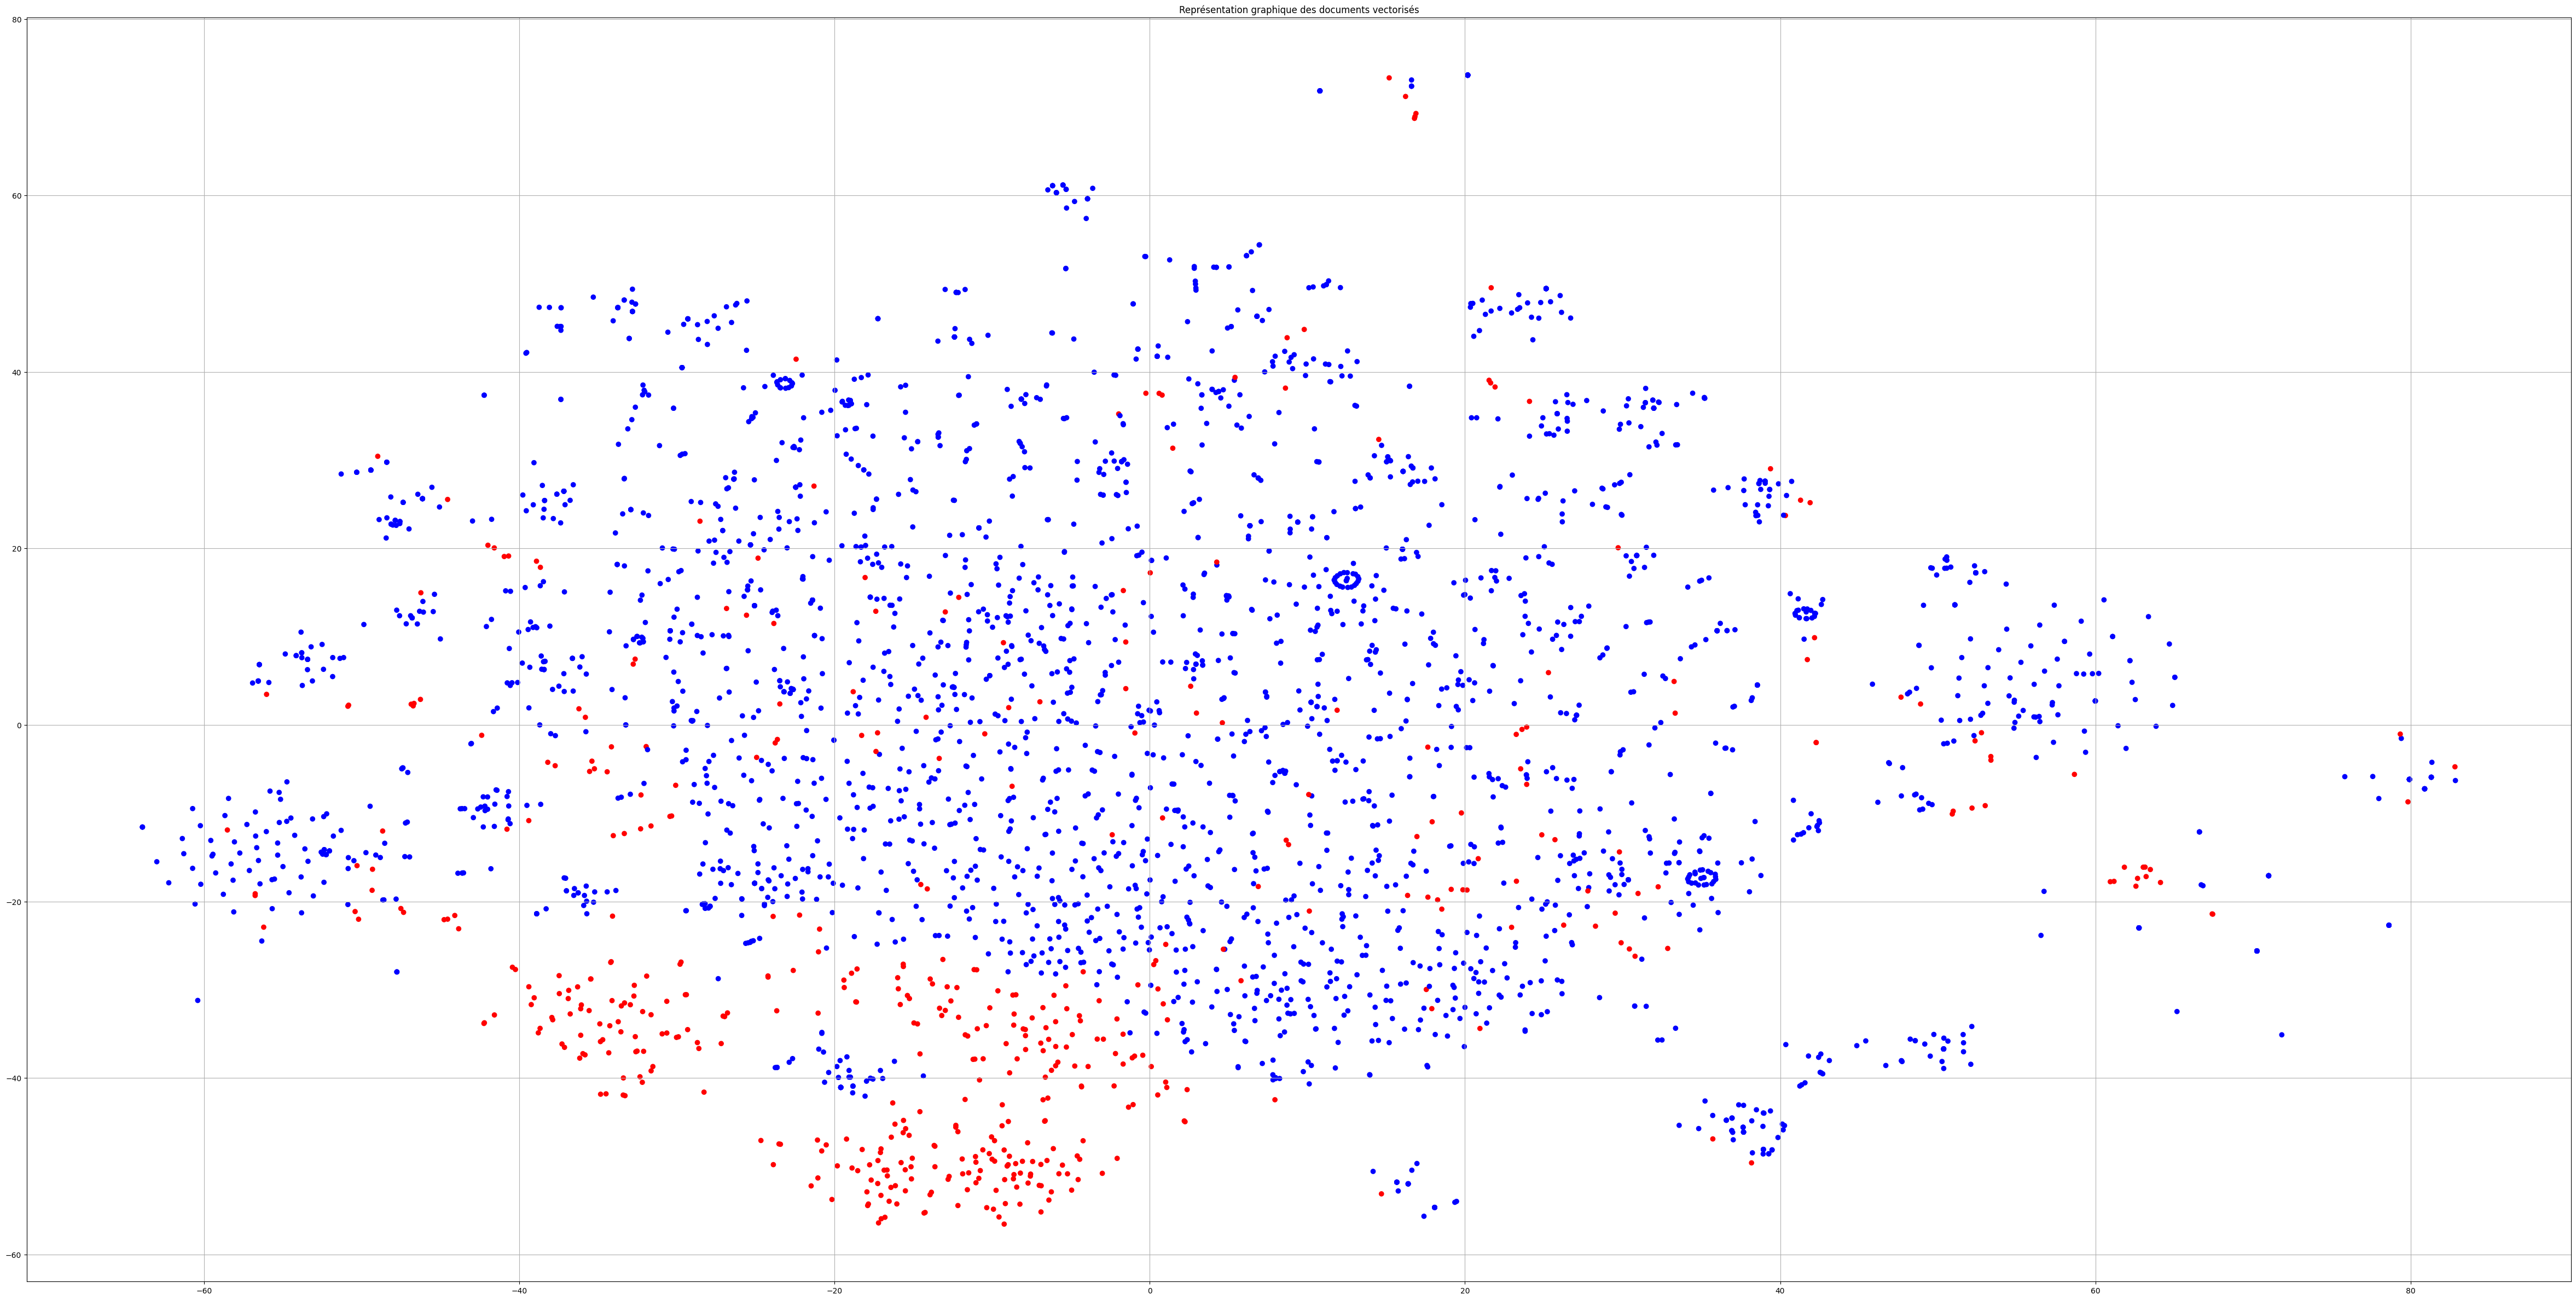

array([[-0.24678329,  0.12556681,  0.01996319, ..., -0.1001235 ,
        -0.00785575, -0.19792338],
       [-0.20530856,  0.17592609,  0.0133449 , ..., -0.19303708,
         0.05247247, -0.23319836],
       [-0.33040616, -0.04434942,  0.26378086, ..., -0.17089991,
        -0.03175143, -0.26263165],
       ...,
       [-0.12120541,  0.18882461, -0.06356676, ...,  0.02386496,
        -0.01105675, -0.29066354],
       [-0.19477817,  0.18117069,  0.0568497 , ...,  0.0003723 ,
         0.03765953, -0.36902636],
       [-0.19373263,  0.13672999,  0.0099001 , ..., -0.0798294 ,
         0.066955  , -0.25152177]])

In [7]:
vectorisation_glove(contaminated, wv, indices)

In [28]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import gensim.downloader as api

In [ ]:
# Vectorisation des données
data_vectors = vectorisation_glove(contaminated, wv, indices)


In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.manifold import TSNE


def detect_anomalies(model, data_vectors):
    """
    Applique le modèle de détection d'anomalies sur les données et retourne les prédictions.
    """
    pred = model.fit_predict(data_vectors)
    return np.where(pred == -1, -1, 1)  # Normalisation des labels (-1 = anomalie, 1 = normal)


def train_autoencoder(data_vectors, contamination_threshold=85):
    """
    Entraîne un autoencodeur pour la détection des anomalies et retourne les prédictions.
    """
    input_dim = data_vectors.shape[1]
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(128, activation='relu')(input_layer)
    encoded = Dense(64, activation='relu')(encoded)
    decoded = Dense(128, activation='relu')(encoded)
    decoded = Dense(input_dim, activation='sigmoid')(decoded)

    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.fit(data_vectors, data_vectors, epochs=50, batch_size=32, shuffle=True, verbose=1)

    reconstructions = autoencoder.predict(data_vectors)
    reconstruction_errors = np.mean(np.square(data_vectors - reconstructions), axis=1)
    thresh = np.percentile(reconstruction_errors, contamination_threshold)
    return np.where(reconstruction_errors > thresh, -1, 1)


def visualiser_resultats(model_name, pred, data_vectors):
    """
    Affiche une visualisation 2D des anomalies détectées par un modèle donné.
    """
    tsne = TSNE(n_components=2, random_state=42)
    vecteurs_2d = tsne.fit_transform(data_vectors)
    couleurs = ['b' if label == 1 else 'r' for label in pred]

    plt.figure(figsize=(10, 6))
    plt.scatter(vecteurs_2d[:, 0], vecteurs_2d[:, 1], c=couleurs, marker='o')
    plt.title(f"Visualisation des anomalies - {model_name}")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.grid(True)
    plt.show()


def evaluer_modeles(models, data_vectors, y_true, afficher_matrice=True, afficher_graphique=True):
    """
    Applique plusieurs modèles de détection d'anomalies et affiche leurs résultats.

    :param models: Dictionnaire des modèles à tester
    :param data_vectors: Données d'entrée
    :param y_true: Vraies étiquettes (ground truth)
    :param afficher_matrice: Afficher la matrice de confusion (bool)
    :param afficher_graphique: Afficher la visualisation des résultats (bool)
    """
    for model_name, model in models.items():
        print(f"\nModèle en cours : {model_name}")

        if model_name == "Autoencodeur":
            pred = train_autoencoder(data_vectors)
        else:
            pred = detect_anomalies(model, data_vectors)

        # Affichage des métriques
        if afficher_matrice:
            print(f"\nMatrice de confusion - {model_name}")
            print(confusion_matrix(y_true, pred))

        print(f"\n{model_name} - Rapport de classification :")
        print(classification_report(y_true, pred))

        # Visualisation des résultats si activé
        if afficher_graphique:
            visualiser_resultats(model_name, pred, data_vectors)




In [39]:
# Définition des modèles
models = {
    "Forêt d'Isolation": IsolationForest(contamination=0.15, random_state=42),
    "One-Class SVM": OneClassSVM(nu=0.15, kernel='rbf', gamma='scale'),
    "DBSCAN": DBSCAN(eps=3, min_samples=5),
    "Autoencodeur": None  # Spécifique, géré séparément
}

# Création des vraies étiquettes (ground truth)
y_true = np.ones(len(data_vectors))  # Tous normaux (1) par défaut
y_true[indices] = -1  # Anomalies injectées = -1

# Exécution de l'évaluation avec options
evaluer_modeles(models, data_vectors, y_true, afficher_matrice=True, afficher_graphique=False)



Modèle en cours : Forêt d'Isolation

Matrice de confusion - Forêt d'Isolation
[[ 160  352]
 [ 342 2565]]

Forêt d'Isolation - Rapport de classification :
              precision    recall  f1-score   support

        -1.0       0.32      0.31      0.32       512
         1.0       0.88      0.88      0.88      2907

    accuracy                           0.80      3419
   macro avg       0.60      0.60      0.60      3419
weighted avg       0.80      0.80      0.80      3419


Modèle en cours : One-Class SVM

Matrice de confusion - One-Class SVM
[[ 145  367]
 [ 367 2540]]

One-Class SVM - Rapport de classification :
              precision    recall  f1-score   support

        -1.0       0.28      0.28      0.28       512
         1.0       0.87      0.87      0.87      2907

    accuracy                           0.79      3419
   macro avg       0.58      0.58      0.58      3419
weighted avg       0.79      0.79      0.79      3419


Modèle en cours : DBSCAN

Matrice de confusion 

Epoch 1/50
107/107 [==============================] - 1s 2ms/step - loss: 0.0561
Epoch 2/50
107/107 [==============================] - 0s 2ms/step - loss: 0.0207
Epoch 3/50
107/107 [==============================] - 0s 2ms/step - loss: 0.0195
Epoch 4/50
107/107 [==============================] - 0s 2ms/step - loss: 0.0189
Epoch 5/50
107/107 [==============================] - 0s 2ms/step - loss: 0.0186
Epoch 6/50
107/107 [==============================] - 0s 2ms/step - loss: 0.0184
Epoch 7/50
107/107 [==============================] - 0s 2ms/step - loss: 0.0182
Epoch 8/50
107/107 [==============================] - 0s 2ms/step - loss: 0.0181
Epoch 9/50
107/107 [==============================] - 0s 2ms/step - loss: 0.0180
Epoch 10/50
107/107 [==============================] - 0s 2ms/step - loss: 0.0178
Epoch 11/50
107/107 [==============================] - 0s 2ms/step - loss: 0.0177
Epoch 12/50
107/107 [==============================] - 0s 2ms/step - loss: 0.0176
Epoch 13/50
107/107 [====

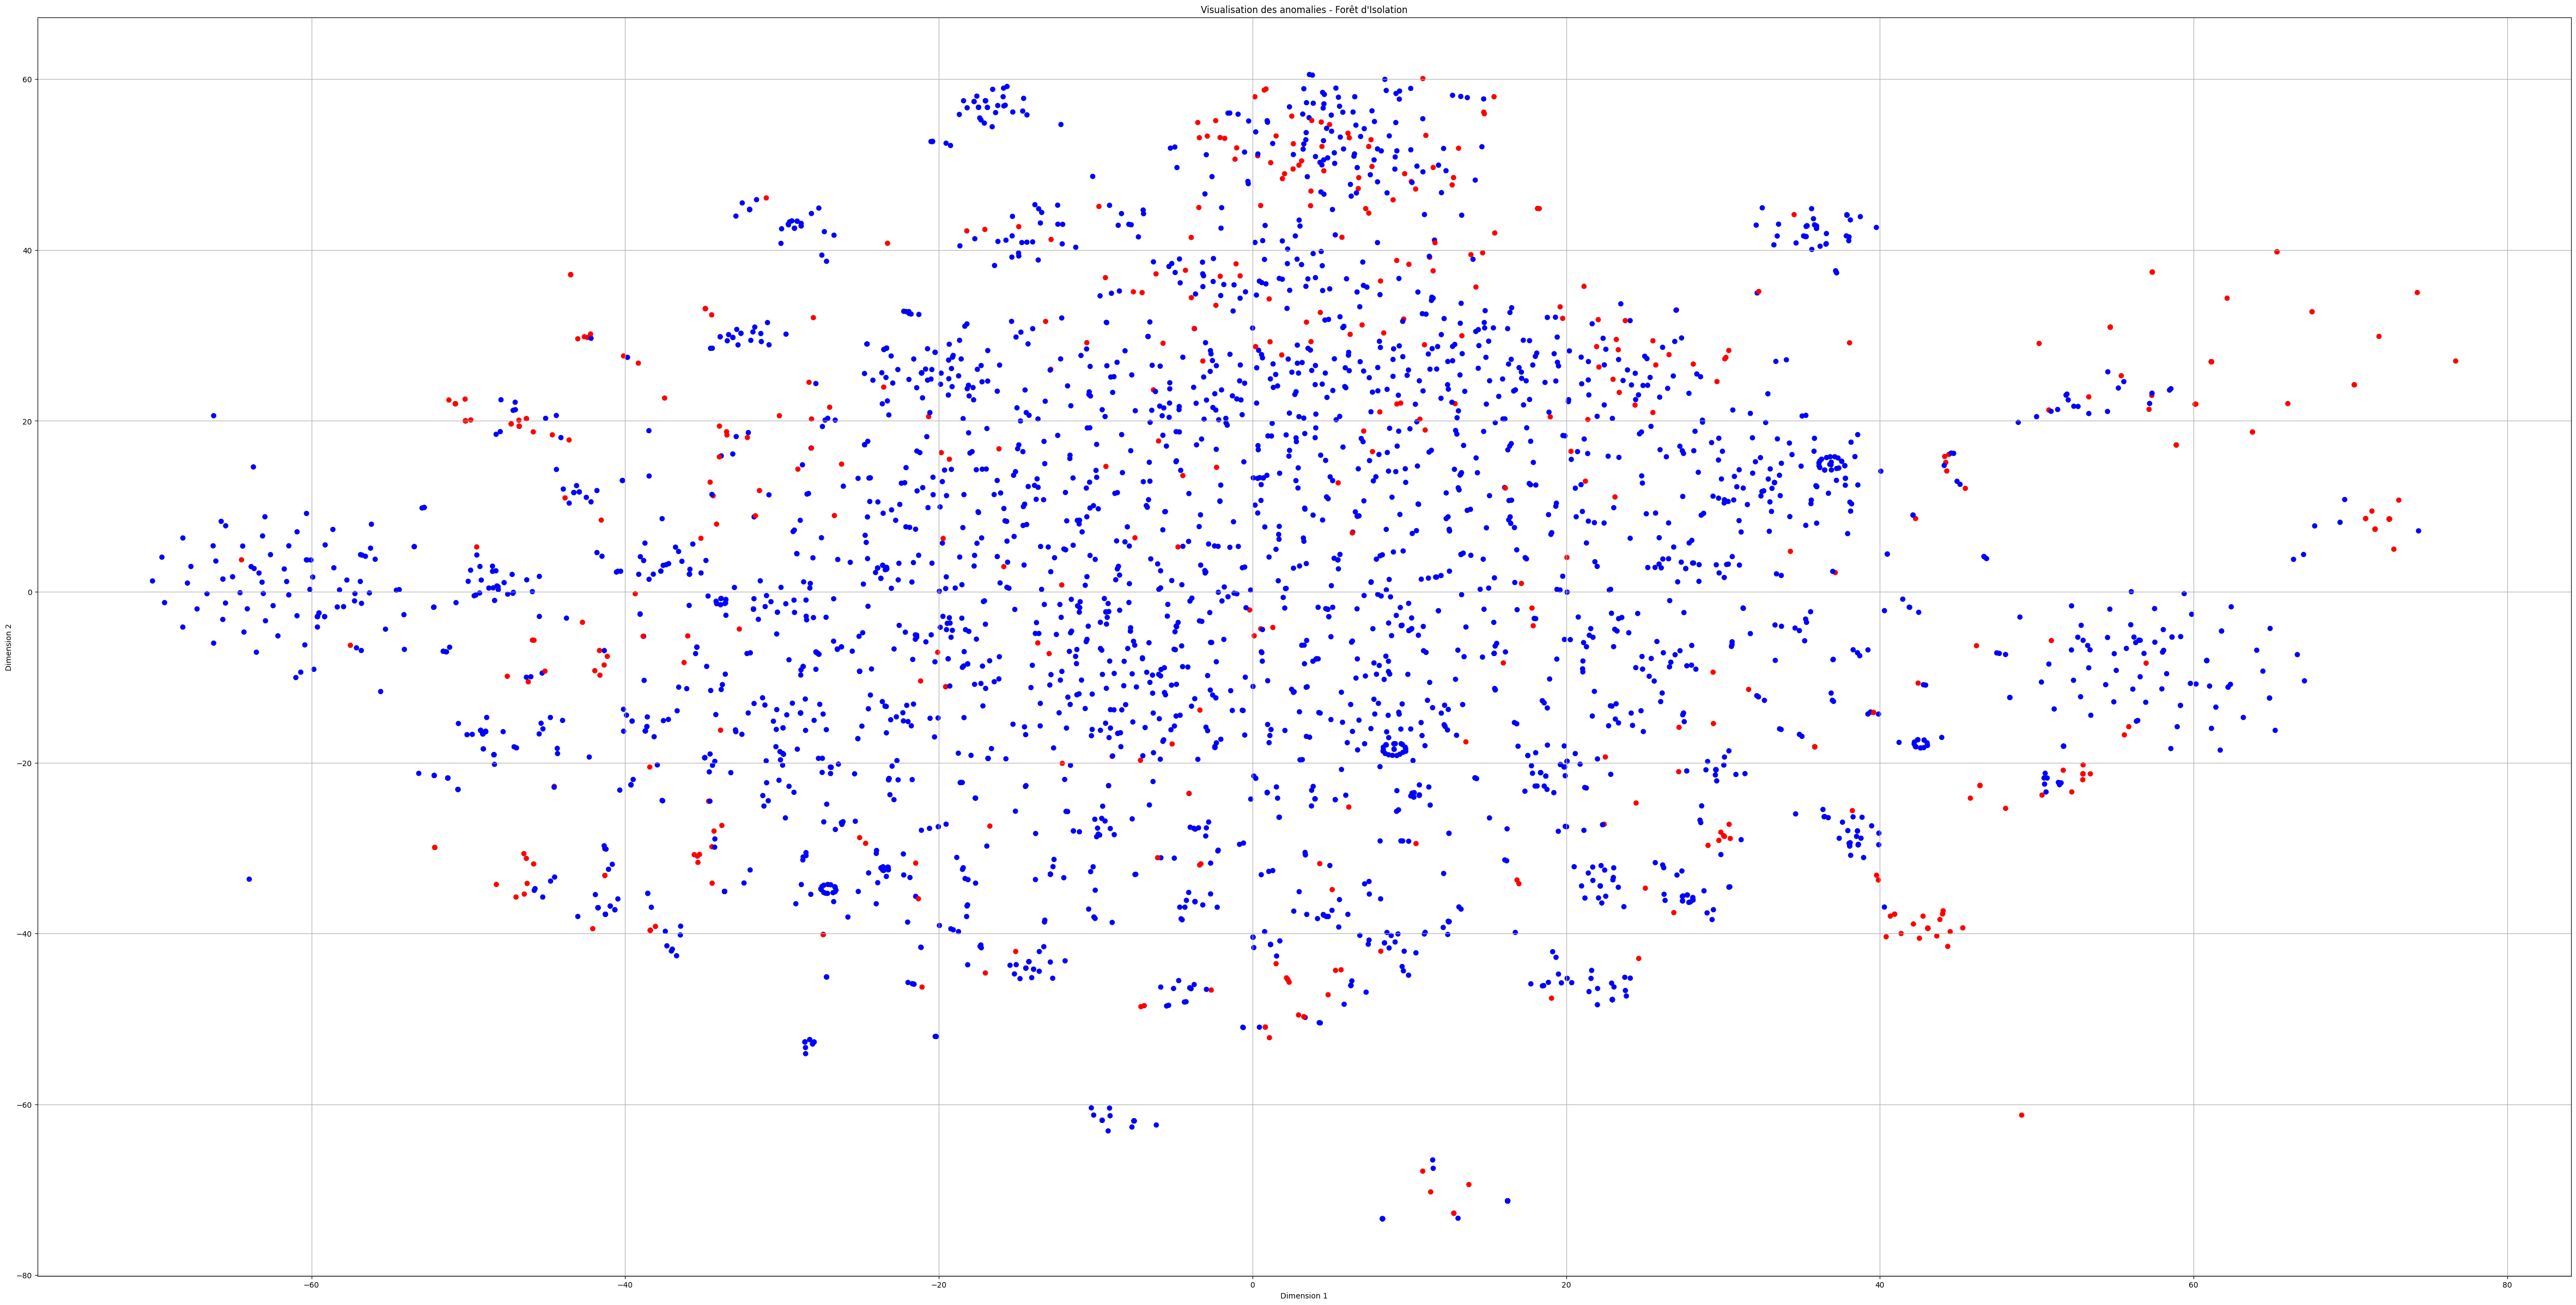


One-Class SVM - Rapport de classification :
              precision    recall  f1-score   support

        -1.0       0.28      0.28      0.28       512
         1.0       0.87      0.87      0.87      2907

    accuracy                           0.79      3419
   macro avg       0.58      0.58      0.58      3419
weighted avg       0.79      0.79      0.79      3419

Accuracy: 0.7853

Matrice de confusion - One-Class SVM
[[ 145  367]
 [ 367 2540]]


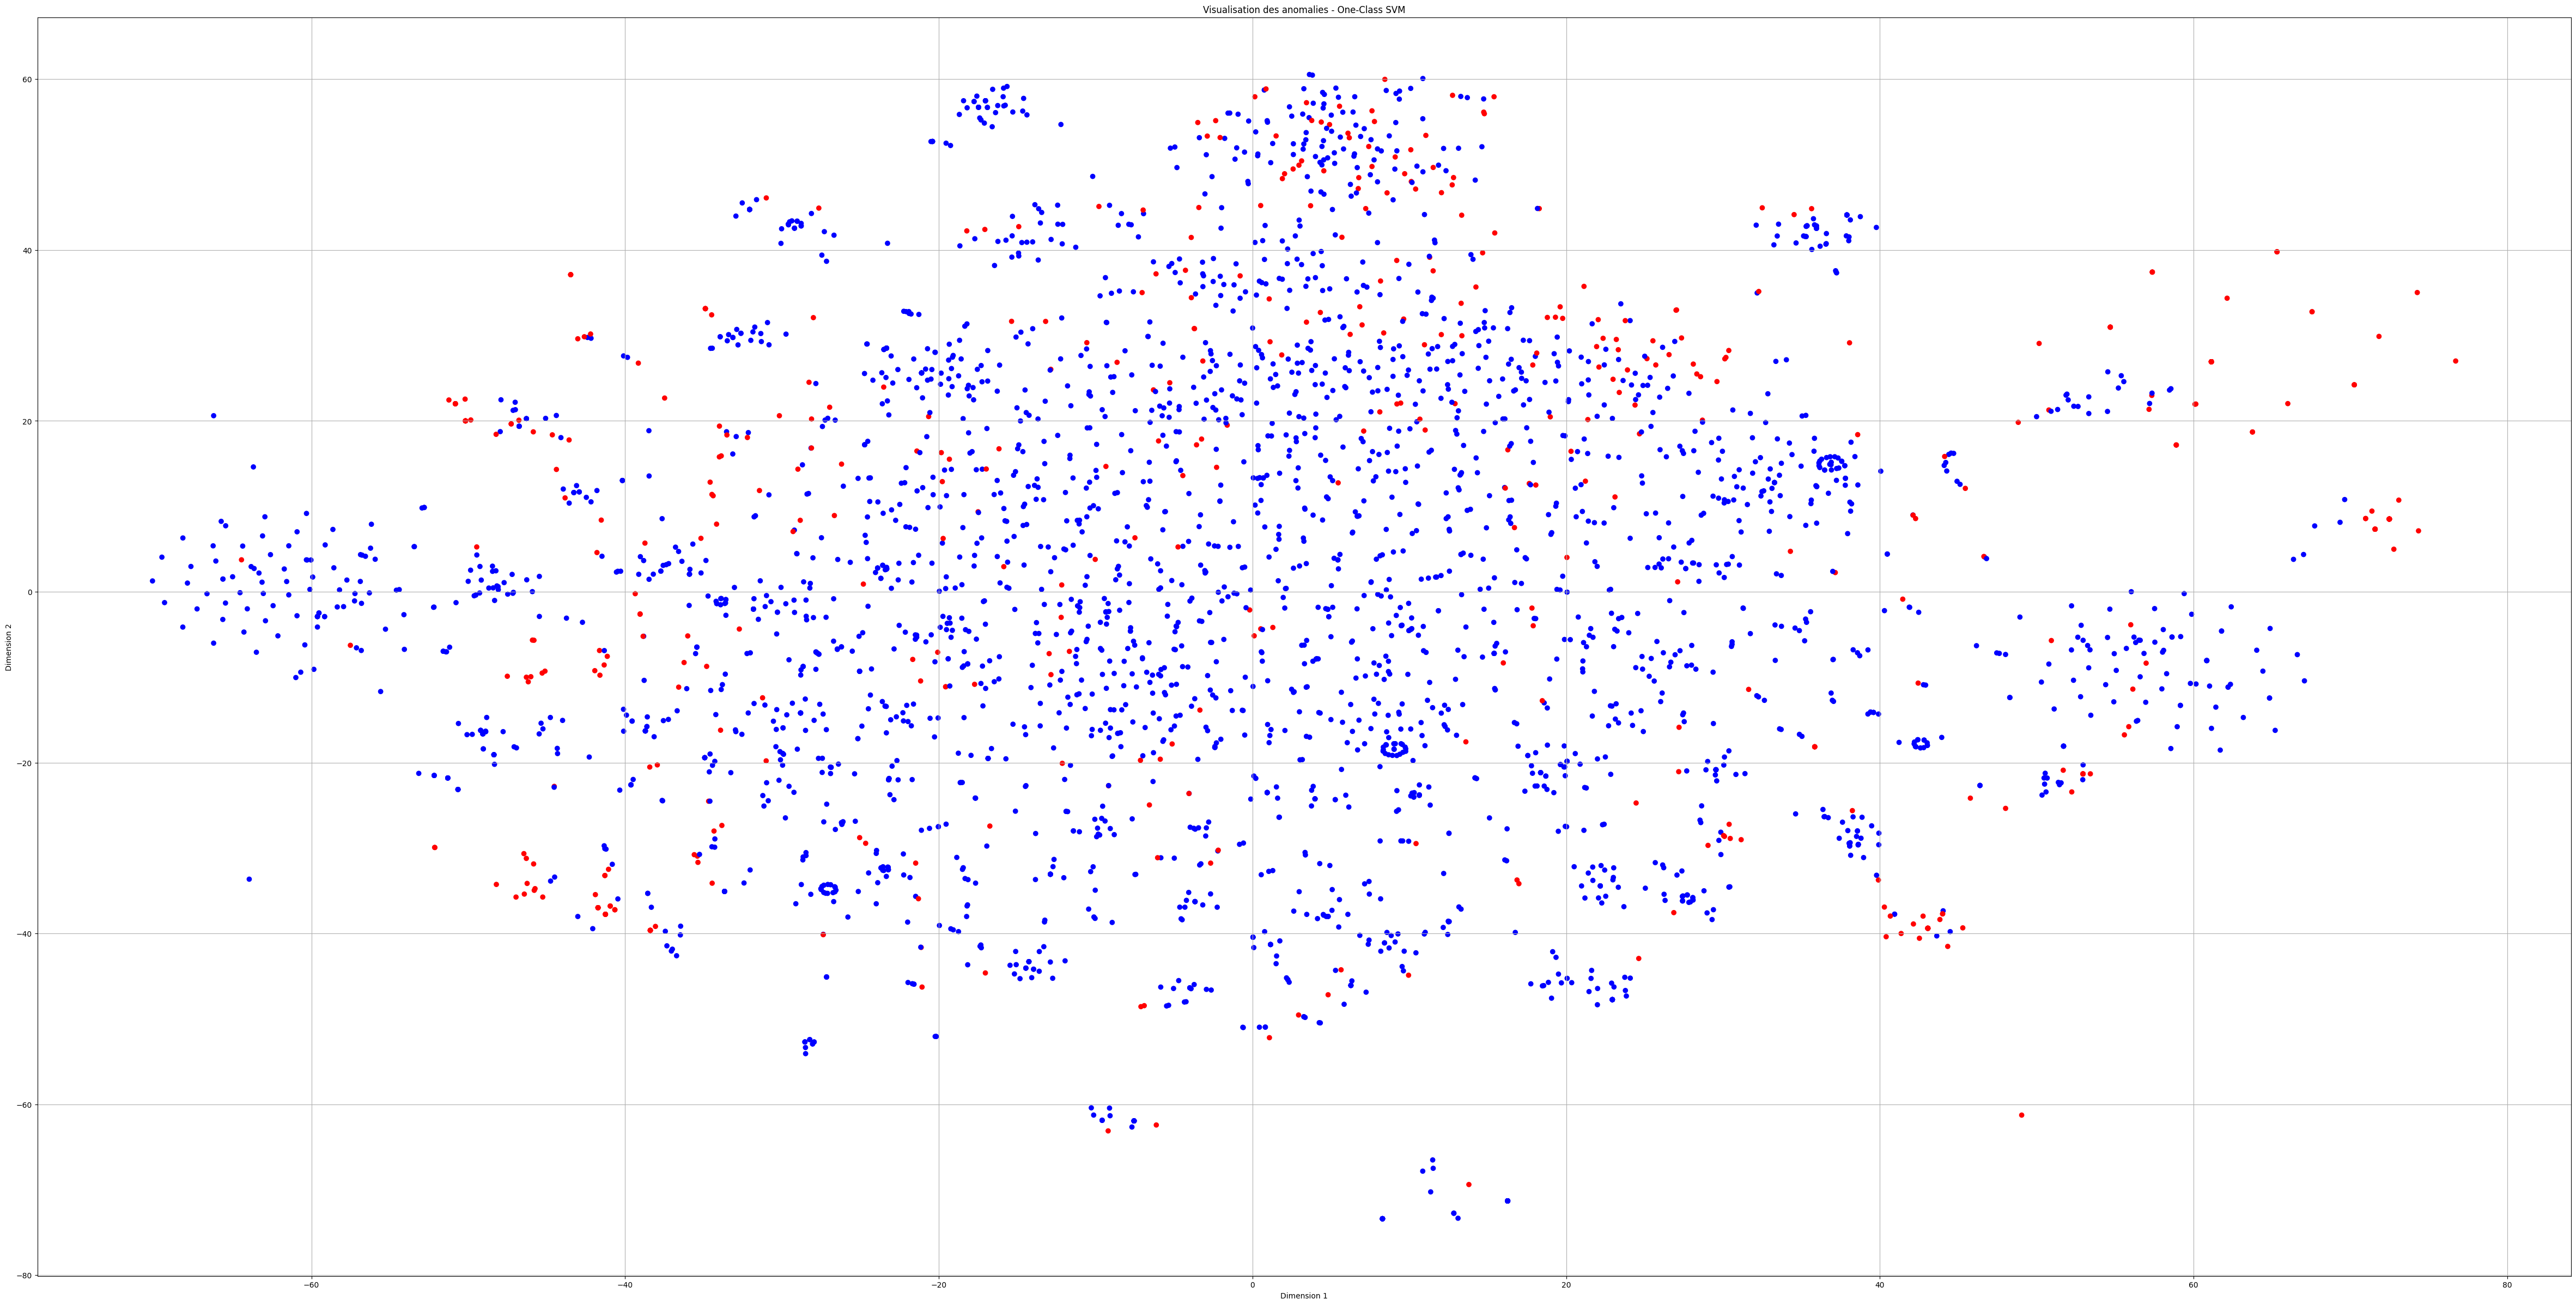


DBSCAN - Rapport de classification :
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00       512
         1.0       0.85      1.00      0.92      2907

    accuracy                           0.85      3419
   macro avg       0.43      0.50      0.46      3419
weighted avg       0.72      0.85      0.78      3419

Accuracy: 0.8494

Matrice de confusion - DBSCAN
[[   0  512]
 [   3 2904]]


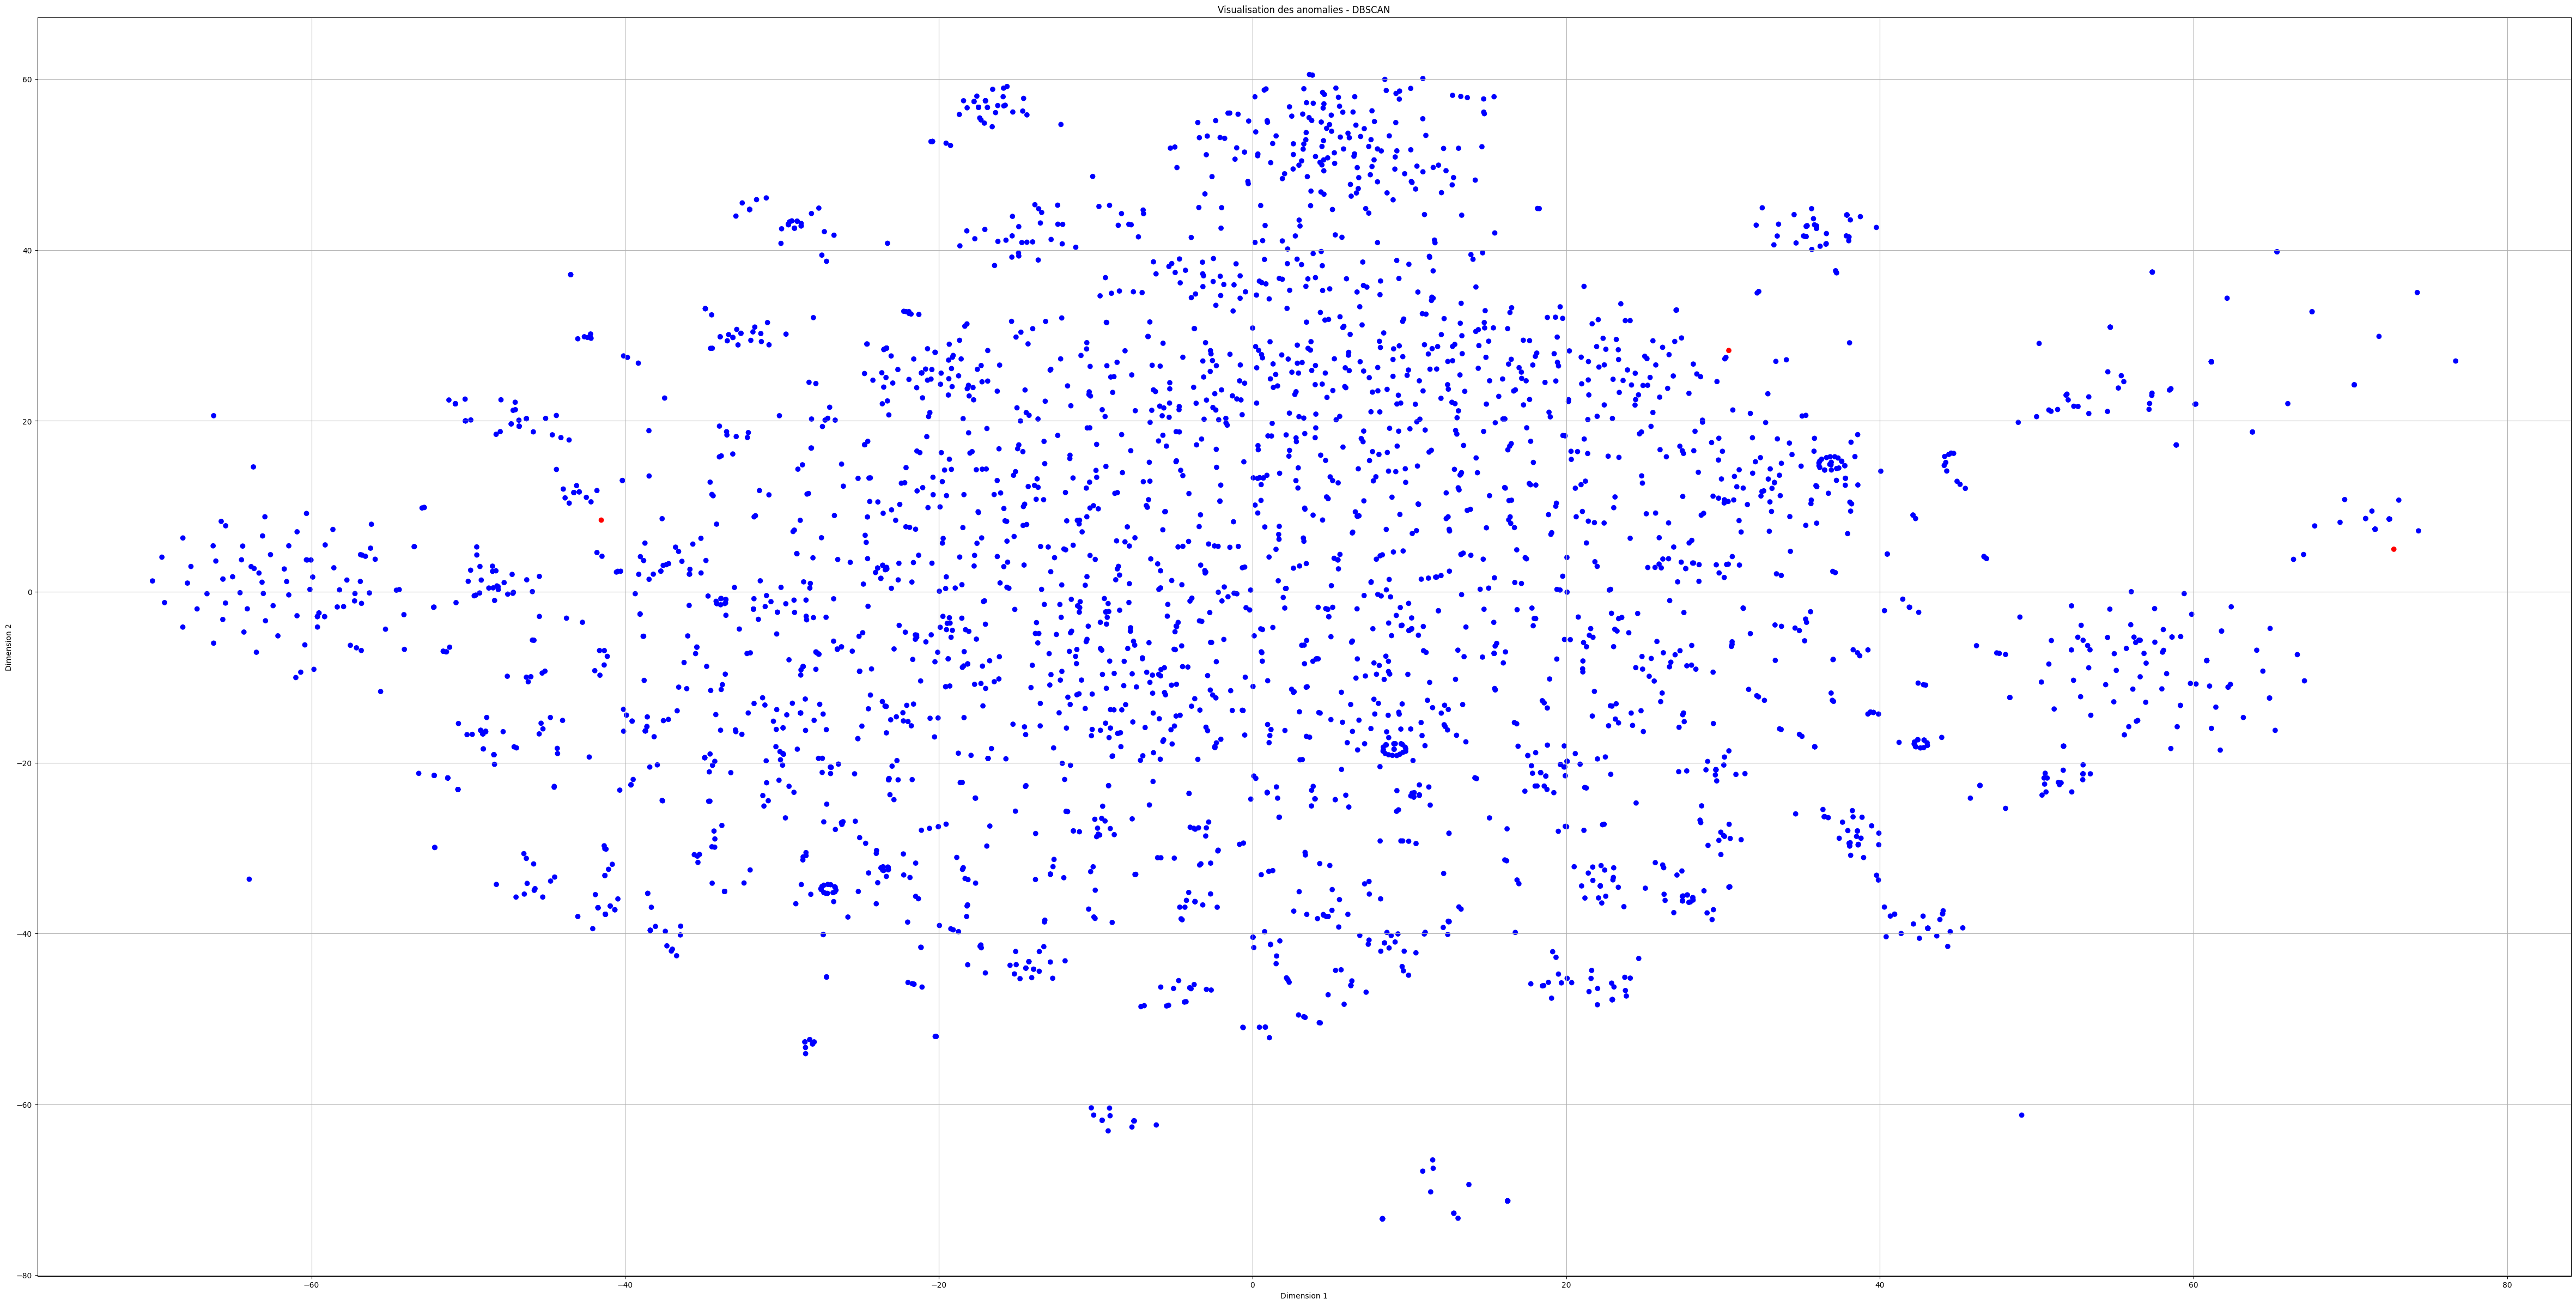


Autoencodeur - Rapport de classification :
              precision    recall  f1-score   support

        -1.0       0.09      0.09      0.09       512
         1.0       0.84      0.84      0.84      2907

    accuracy                           0.73      3419
   macro avg       0.46      0.46      0.46      3419
weighted avg       0.73      0.73      0.73      3419

Accuracy: 0.7277

Matrice de confusion - Autoencodeur
[[  46  466]
 [ 465 2442]]


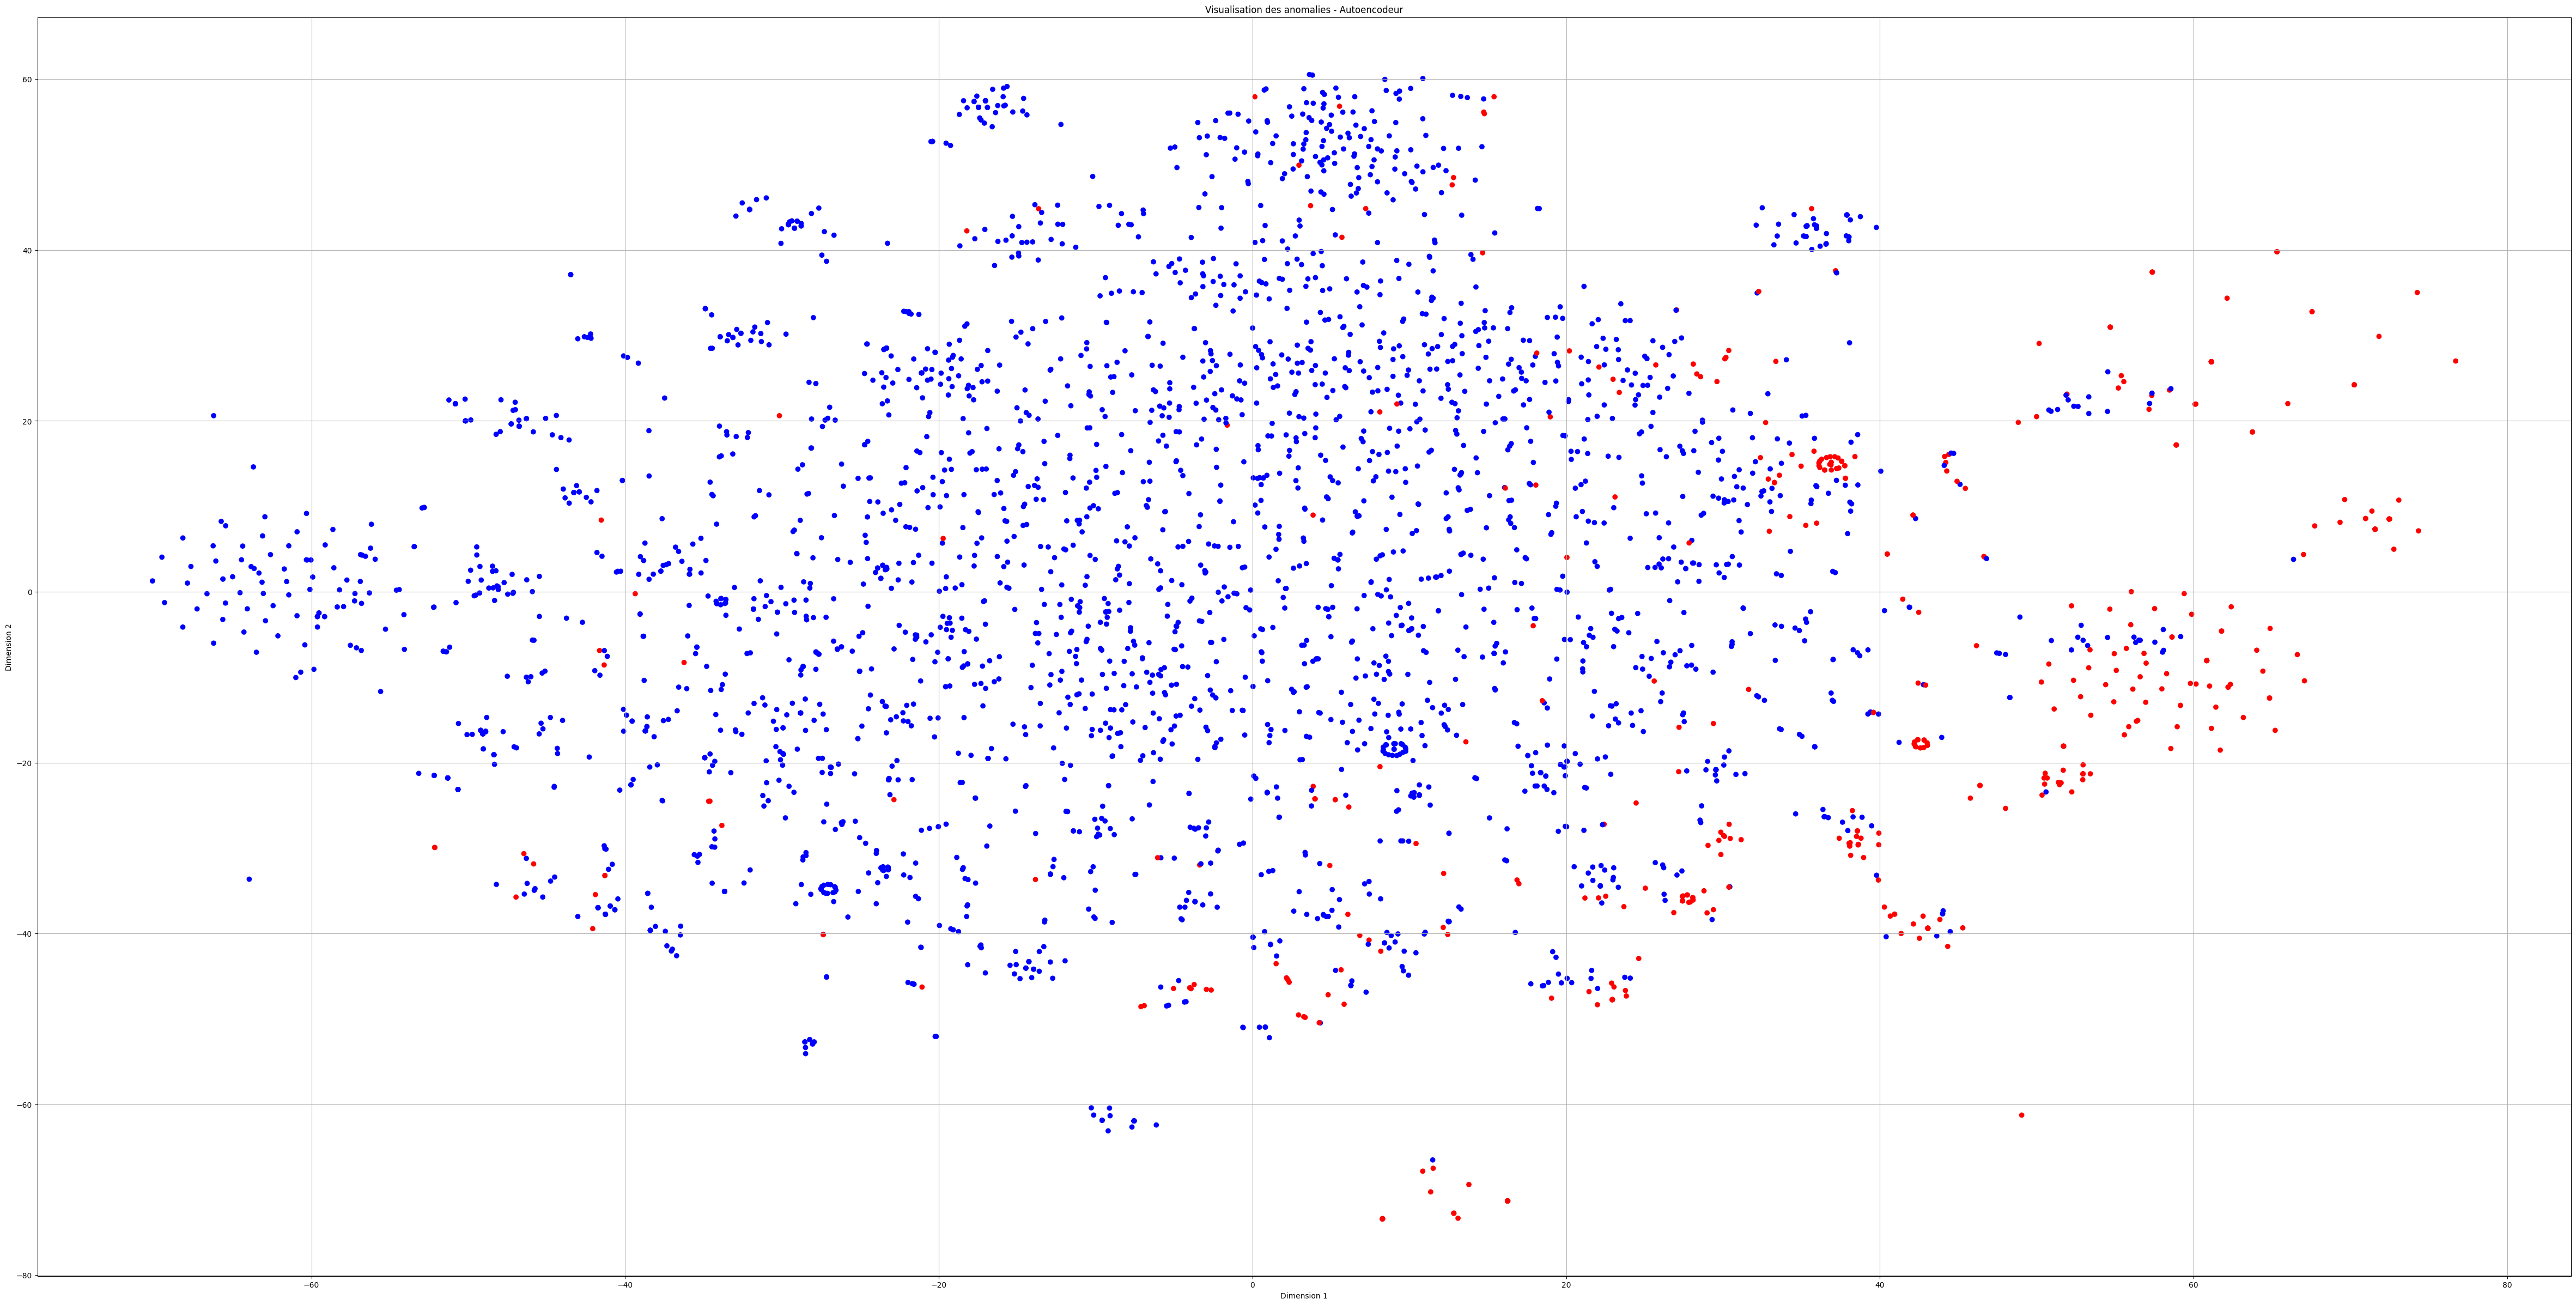

In [32]:
## Isolation Forest
iso_forest = IsolationForest(contamination=0.15, random_state=42)
iso_pred = iso_forest.fit_predict(data_vectors)

## One-Class SVM
oc_svm = OneClassSVM(nu=0.15, kernel='rbf', gamma='scale')
oc_pred = oc_svm.fit_predict(data_vectors)

## DBSCAN
dbscan = DBSCAN(eps=3, min_samples=5)
db_pred = dbscan.fit_predict(data_vectors)

# Correction des labels
iso_pred = np.where(iso_pred == -1, -1, 1)  # Anomalies = -1, Normaux = 1
oc_pred = np.where(oc_pred == -1, -1, 1)  # Idem
db_pred = np.where(db_pred == -1, -1, 1)  # Seules les -1 sont anomalies, le reste est normal (1)

# Autoencodeur
input_dim = data_vectors.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(data_vectors, data_vectors, epochs=50, batch_size=32, shuffle=True, verbose=1)

# Détection des anomalies avec l'autoencodeur
reconstructions = autoencoder.predict(data_vectors)
reconstruction_errors = np.mean(np.square(data_vectors - reconstructions), axis=1)
thresh = np.percentile(reconstruction_errors, 85)
ae_pred = np.where(reconstruction_errors > thresh, -1, 1)  # Anomalies = -1, Normaux = 1

# Création des vraies étiquettes (ground truth)
y_true = np.ones(len(data_vectors))  # Tous normaux (1) par défaut
y_true[indices] = -1  # Anomalies injectées = -1

# Résumé des prédictions
predictions = {
    "Forêt d'Isolation": iso_pred,
    "One-Class SVM": oc_pred,
    "DBSCAN": db_pred,
    "Autoencodeur": ae_pred
}

# Fonction de visualisation des anomalies pour un seul modèle à la fois
def visualiser_resultats(model_name, pred, data_vectors):
    """
    Fonction pour afficher les anomalies (en rouge) et les documents normaux (en bleu) dans un espace 2D 
    pour un modèle donné.
    """
    tsne = TSNE(n_components=2, random_state=42)
    vecteurs_2d = tsne.fit_transform(data_vectors)

    # Définir les couleurs (rouge pour anomalies, bleu pour normaux)
    couleurs = ['b' if label == 1 else 'r' for label in pred]

    # Affichage des points
    plt.figure(figsize=(60, 30))
    plt.scatter(vecteurs_2d[:, 0], vecteurs_2d[:, 1], c=couleurs, marker='o')
    plt.title(f"Visualisation des anomalies - {model_name}")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.grid(True)
    plt.show()


# Visualisation des anomalies pour chaque modèle avant les métriques
for model, pred in predictions.items():
    
    
    # Affichage des métriques d'évaluation après la visualisation
    print(f"\n{model} - Rapport de classification :")
    print(classification_report(y_true, pred))
    print(f"Accuracy: {accuracy_score(y_true, pred):.4f}")
    print(f"\nMatrice de confusion - {model}")
    print(confusion_matrix(y_true, pred))
    visualiser_resultats(model, pred, data_vectors)



In [24]:
# Modèles non supervisés
## Isolation Forest
iso_forest = IsolationForest(contamination=0.15, random_state=42)
iso_forest.fit(X_train)
iso_pred = iso_forest.predict(X_test)

## One-Class SVM
oc_svm = OneClassSVM(nu=0.15, kernel='rbf', gamma='scale')
oc_svm.fit(X_train)
oc_pred = oc_svm.predict(X_test)

## DBSCAN
dbscan = DBSCAN(eps=3, min_samples=5)
dbscan.fit(X_train)
db_pred = dbscan.fit_predict(X_test)
# Autoencodeur
input_dim = data_vectors.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(data_vectors, data_vectors, epochs=50, batch_size=32, shuffle=True, verbose=1)

# Détection des anomalies avec l'autoencodeur
reconstructions = autoencoder.predict(data_vectors)
reconstruction_errors = np.mean(np.square(data_vectors - reconstructions), axis=1)
thresh = np.percentile(reconstruction_errors, 85)
ae_pred = (reconstruction_errors > thresh).astype(int)

# Visualisation des résultats
def visualiser_resultats(predictions, data_vectors):
    for model, pred in predictions.items():
        couleurs = ['b' if p == 1 else 'r' for p in pred]
        tsne = TSNE(n_components=2, random_state=42)
        vecteurs_2d = tsne.fit_transform(data_vectors)
        
        plt.figure(figsize=(60, 30))
        plt.scatter(vecteurs_2d[:, 0], vecteurs_2d[:, 1], c=couleurs, marker='o')
        plt.title(f"Visualisation des anomalies détectées - {model}")
        plt.grid(True)
        plt.show()

# Résumé des prédictions
predictions = {
    "Isolation Forest": iso_pred,
    "One-Class SVM": oc_pred,
    "DBSCAN": db_pred,
    "Autoencoder": ae_pred
}

visualiser_resultats(predictions, data_vectors)

for model, pred in predictions.items():
    print(f"{model} - Nombre d'anomalies détectées: {sum(pred == -1) if -1 in pred else sum(pred)}")


In [36]:
labels = [0] * len(base_texts)  # 0 pour normal
for idx in indices:
    labels[idx] = 1

# Combiner les textes normaux et contaminés
all_texts = base_texts.tolist() + contaminated.tolist()

# Combiner les labels
all_labels = labels + [1] * len(contaminated) 



In [9]:
def contamination_function_bis(data1, data2, contamination_rate=0.1):
    """
    Fonction qui génère des anomalie dans notre jeu de données data1, en injectant des donnée de data2.
    
    - data1 : Corpus de données sain
    - data2 : Corpus de données considérées "anomalie"
    - contamination_rate : le taux de document contaminé par rapport a la taille de data1
    
    retourne un nouveau corpus de données avec des anomalies + les indices des anomalies
    """
    contamination_log = []
    
    #on contamine % des documents dans data1 
    df_size = max(1, int(len(data1) * contamination_rate))  
    selected_indices = random.sample(range(len(data1)), df_size)
    
    for i in selected_indices:
        base_text = data1[i]
        new_text = random.choice(data2)
        data1[i] = new_text  # remplacement de la ligne 

        # un log pour surveiller le fonctionnement de la fonction (à ajouter dans le return)
        contamination_log.append({
            "base_text": base_text,  # le texte original avant remplacement
            "contaminated_text": new_text,  # le texte après remplacement
            "index_replaced": i  # l'index de la ligne modifiée
        })

    return data1, selected_indices

In [10]:
data_new, ind= contamination_function_bis(base_texts, anomaly_texts)

In [18]:
#data_new.to_csv("contaminated_data.csv", index = False)

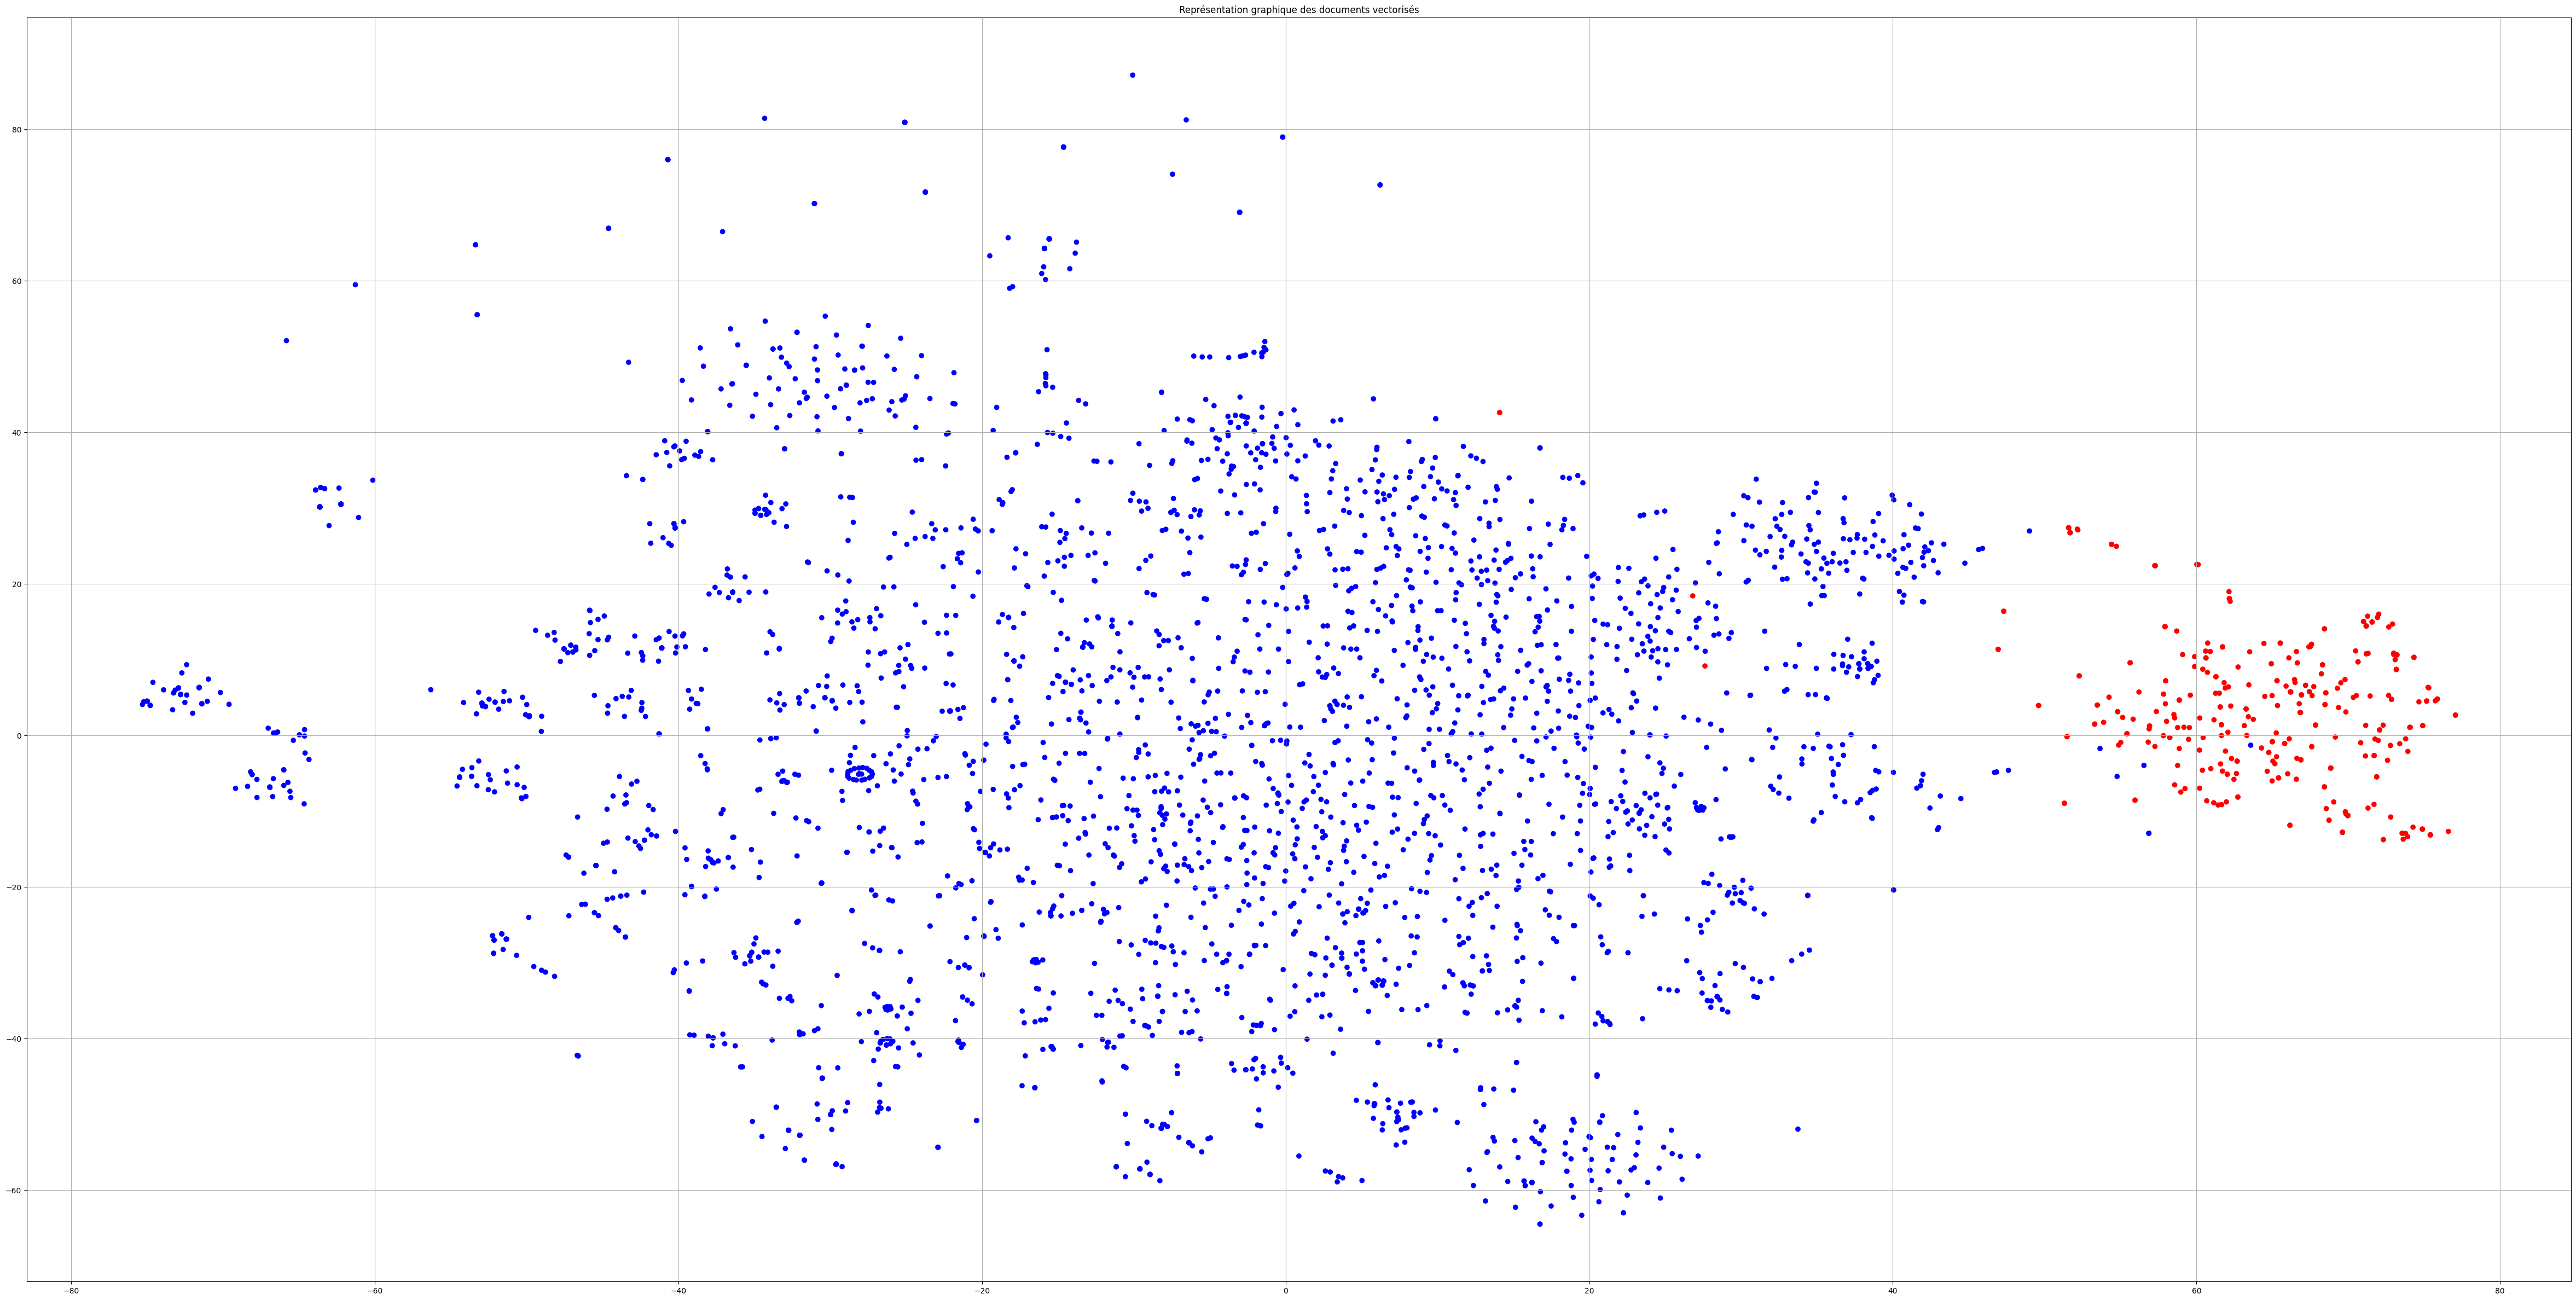

In [11]:
X_glove = vectorisation_glove(data_new, wv, ind)

In [12]:
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X_glove, test_size=0.2, random_state=42)

# Initialisation et entraînement du modèle sur les données d'entraînement
model_iforest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
model_iforest.fit(X_train)

# Prédiction sur l'ensemble d'entraînement et de test
y_pred_train = model_iforest.predict(X_train)
y_pred_test = model_iforest.predict(X_test)


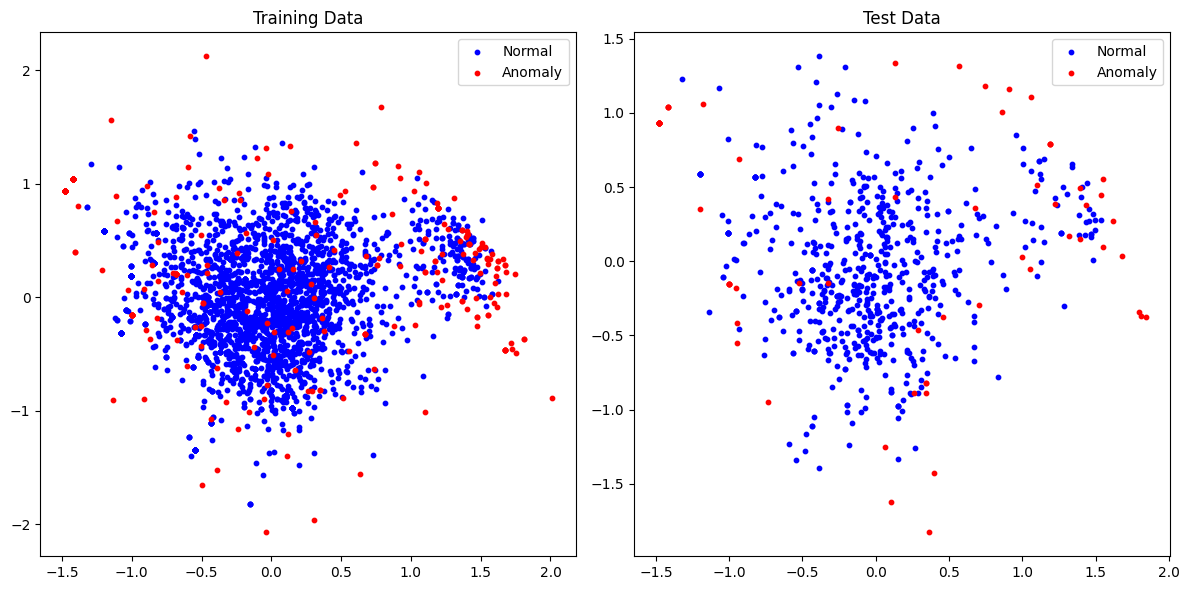

In [13]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Fonction pour afficher les anomalies détectées
def create_scatter_plots(X1, y1, title1, X2, y2, title2):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Scatter plot pour les données d'entraînement
    axes[0].scatter(X1[y1 == 1, 0], X1[y1 == 1, 1], color='blue', label='Normal', s=10)
    axes[0].scatter(X1[y1 == -1, 0], X1[y1 == -1, 1], color='red', label='Anomaly', s=10)
    axes[0].set_title(title1)
    axes[0].legend()

    # Scatter plot pour les données de test
    axes[1].scatter(X2[y2 == 1, 0], X2[y2 == 1, 1], color='blue', label='Normal', s=10)
    axes[1].scatter(X2[y2 == -1, 0], X2[y2 == -1, 1], color='red', label='Anomaly', s=10)
    axes[1].set_title(title2)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# Affichage des anomalies détectées
create_scatter_plots(X_train_pca, y_pred_train, 'Training Data', X_test_pca, y_pred_test, 'Test Data')